#**IMPORT NECESSARY LIBRARIES**

In [1]:
import numpy as np
import requests
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# **DEFINING THE FUNCTION TO DOWNLOAD IMAGES AND FINDING COORDINATES OF WHITE PIXELS**

In [2]:
def process_image(url , i):
    response = requests.get(url)
    if response.status_code == 200:
        image_name = "image.png"
        with open(image_name, "wb") as f:
            f.write(response.content)
        image = cv2.imread(image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


        # Applying binary thresholding to images
        _, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

        # Showing the binary thresholded images
        plt.imshow(thresh, cmap='gray')
        plt.title("Binary Thresholded Image {}".format(i+1))
        plt.show()
        print("\n \n")

        # Extracting coordinates of white pixels
        data = np.argwhere(thresh == 255)  # Get coordinates of white pixels
        return data
    else:
        print("Failed to download the image.")
        return None


#**DOWNLOAD AND SHOWING IMAGES**

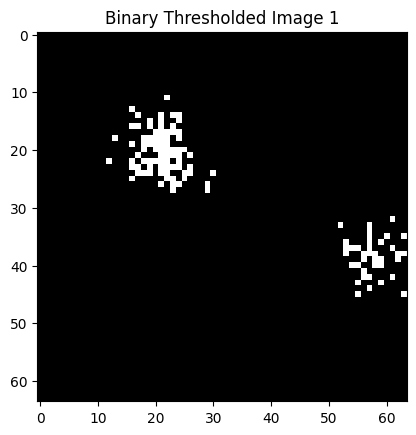

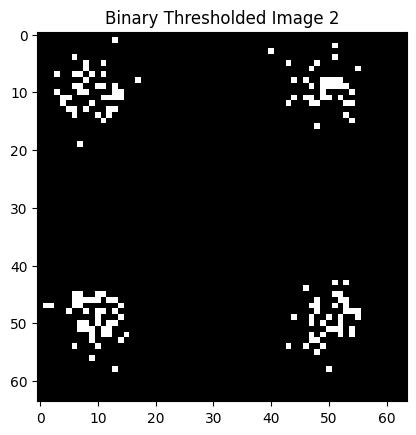

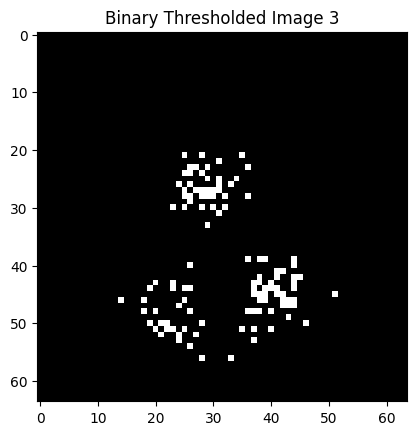

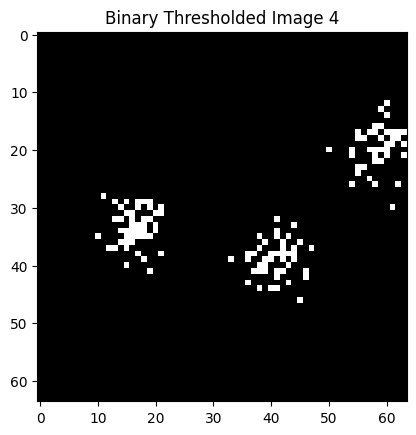

In [3]:
urls = [
    "https://drive.google.com/uc?id=1npBoN6pINjyAg0uGZFwkoARODSHfpBgA",
    "https://drive.google.com/uc?id=1pS9gl6yXuVe-9u6R1OPfxhm6PaF7nFXm",
    "https://drive.google.com/uc?id=13uNVgaaT_DmY82Lde-HRk28dce6i15Wy",
    "https://drive.google.com/uc?id=1l3IFRmox4_0cFizcUpuys5mfX4emkS8C"
]

data_list = [process_image(url, i) for i, url in enumerate(urls)]
processed_images = [data for data in data_list if data is not None]


#**DEFINING DBSCAN ALGORITHM AND MORE FUNCTIONS**

In [4]:
def find_neighbors(X, point_index, eps):
    neighbors = []
    for i, point in enumerate(X):
        if np.linalg.norm(X[point_index] - point) <= eps:
            neighbors.append(i)
    return neighbors

# DBSCAN Clustering
def dbscan_clustering(X, eps, min_samples):
    cluster_labels = np.zeros(len(X), dtype=int)
    cluster_count = 0

    for i, point in enumerate(X):
        if cluster_labels[i] != 0:
            continue  # Skip already classified points

        neighbors = find_neighbors(X, i, eps)
        if len(neighbors) < min_samples:
            cluster_labels[i] = -1  # Marking as noise
            continue

        cluster_count += 1
        cluster_labels[i] = cluster_count

        # Expanding the cluster
        j = 0
        while j < len(neighbors):
            neighbor_index = neighbors[j]
            if cluster_labels[neighbor_index] == -1:  # Updating noise points to border points
                cluster_labels[neighbor_index] = cluster_count
            elif cluster_labels[neighbor_index] == 0:
                cluster_labels[neighbor_index] = cluster_count
                neighbor_neighbors = find_neighbors(X, neighbor_index, eps)
                if len(neighbor_neighbors) >= min_samples:
                    neighbors.extend(neighbor_neighbors)
            j += 1

    return cluster_labels


#**FUNCTION TO VISUALIZE DBSCAN CLUSTER**

In [5]:
def visualize_dbscan_clusters(X, cluster_labels, centroids):
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        if label == -1:
            plt.scatter(X[cluster_labels == label][:, 1], X[cluster_labels == label][:, 0], c='gray', marker='o', label='Noise')
        else:
            plt.scatter(X[cluster_labels == label][:, 1], X[cluster_labels == label][:, 0], marker='o', label=f'Cluster {label}')

    # Plotting centroids for the data
    for centroid in centroids:
        plt.scatter(centroid[1], centroid[0], c='black', marker='X', s=200)

    if len(centroids) > 0:
        plt.scatter([], [], c='black', marker='X', s=200, label='Centroid')

    plt.title('DBSCAN Clustering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.show()


#**CALCULAATE DISTANCE BETWEEN THE CENTROIDS**

In [6]:
def calculate_distances(centroids):
    distances = []
    labels = []
    for i, c1 in enumerate(centroids):
        for j, c2 in enumerate(centroids):
            if i < j:
                distance = np.linalg.norm(c1 - c2)
                distances.append(distance)
                labels.append(f'Cluster {i+1} to Cluster {j+1}')
    return distances, labels


#**RUNNING DBSCAN CLUSTERING FOR EACH DATASET**

Number of clusters found by DBSCAN for image 1 = 2




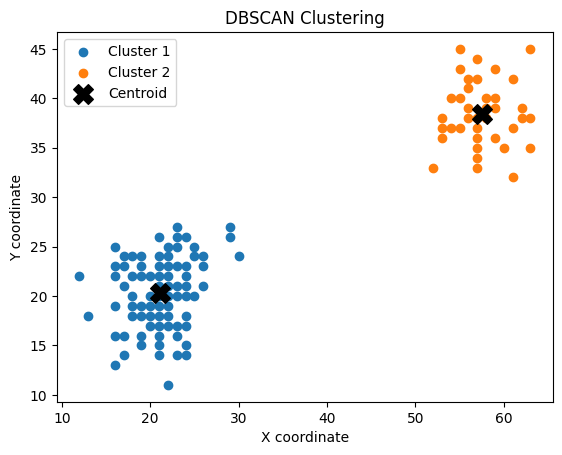


 Distances between centroids: 
 
                         Distance
Cluster 1 to Cluster 2  40.681477

 
 

Number of clusters found by DBSCAN for image 2 = 4




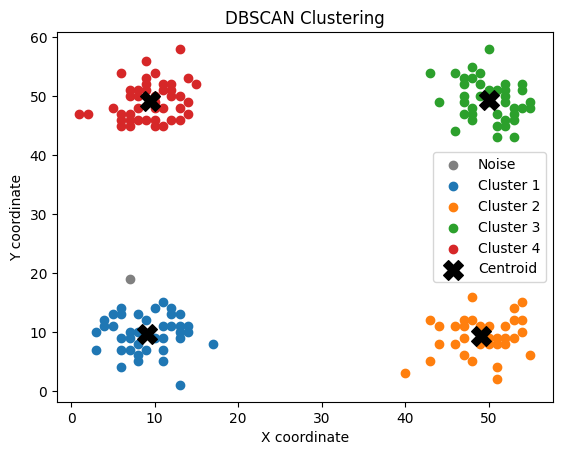


 Distances between centroids: 
 
                         Distance
Cluster 1 to Cluster 2  40.068584
Cluster 1 to Cluster 3  57.010893
Cluster 1 to Cluster 4  39.492832
Cluster 2 to Cluster 3  40.137182
Cluster 2 to Cluster 4  56.339962
Cluster 3 to Cluster 4  40.607415

 
 

Number of clusters found by DBSCAN for image 3 = 3




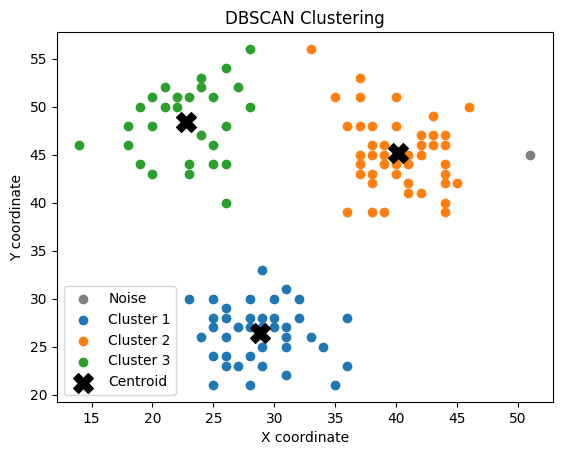


 Distances between centroids: 
 
                         Distance
Cluster 1 to Cluster 2  21.920981
Cluster 1 to Cluster 3  22.795681
Cluster 2 to Cluster 3  17.678042

 
 

Number of clusters found by DBSCAN for image 4 = 3




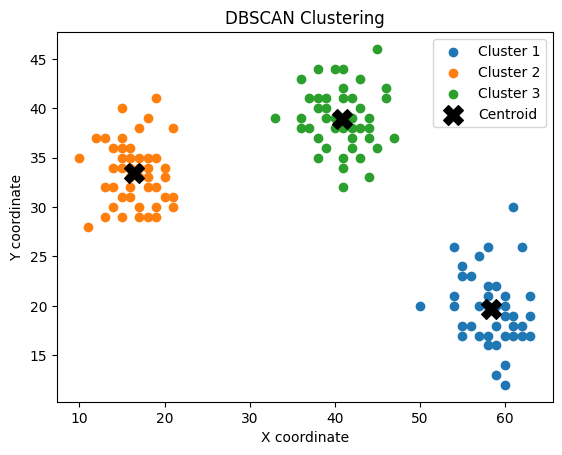


 Distances between centroids: 
 
                         Distance
Cluster 1 to Cluster 2  44.158775
Cluster 1 to Cluster 3  26.075866
Cluster 2 to Cluster 3  24.969671

 
 



In [7]:
for i, X in enumerate(processed_images):

    eps = 5  # Adjusting on the basis of the scale of data
    min_samples = 5  # Adjusting on the basis of expected density of clusters

    cluster_labels = dbscan_clustering(X, eps, min_samples)
    unique_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # Excluding noise points
    print("Number of clusters found by DBSCAN for image {} = {}".format(i+1 , unique_clusters))
    print("\n")

    # Calculating centroids
    centroids = []
    for label in range(1, unique_clusters + 1):
        cluster_points = X[cluster_labels == label]
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)

    visualize_dbscan_clusters(X, cluster_labels, centroids)

    # Calculating distances between centroids and forming a table
    distances, labels = calculate_distances(np.array(centroids))
    df = pd.DataFrame({'Distance': distances}, index=labels)
    print("\n Distances between centroids: \n ")
    print(df)
    print("\n \n \n")
